In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 2: Navigate to your file or folder
# Example: Access a CSV file stored in 'My Drive'
import pandas as pd

file_path = '/content/drive/My Drive/Loan Approval/train.csv'
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.1 MB/s eta 0:00:00


In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from optuna.samplers import TPESampler
import shap

In [6]:
df.shape

(58645, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [8]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [9]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
df.isnull().sum()

,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


In [11]:
df.nunique()

,0
id,58645
person_age,53
person_income,2641
person_home_ownership,4
person_emp_length,36
loan_intent,6
loan_grade,7
loan_amnt,545
loan_int_rate,362
loan_percent_income,61


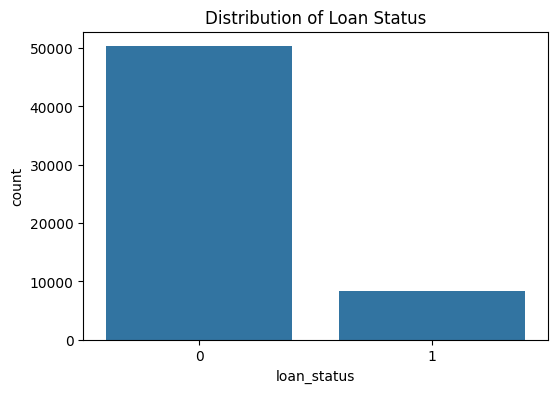

Loan status distribution in percentage:
 loan_status
0    85.761787
1    14.238213
Name: proportion, dtype: float64


In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='loan_status')
plt.title("Distribution of Loan Status")
plt.show()

loan_status_counts = df['loan_status'].value_counts(normalize=True) * 100
print("Loan status distribution in percentage:\n", loan_status_counts)

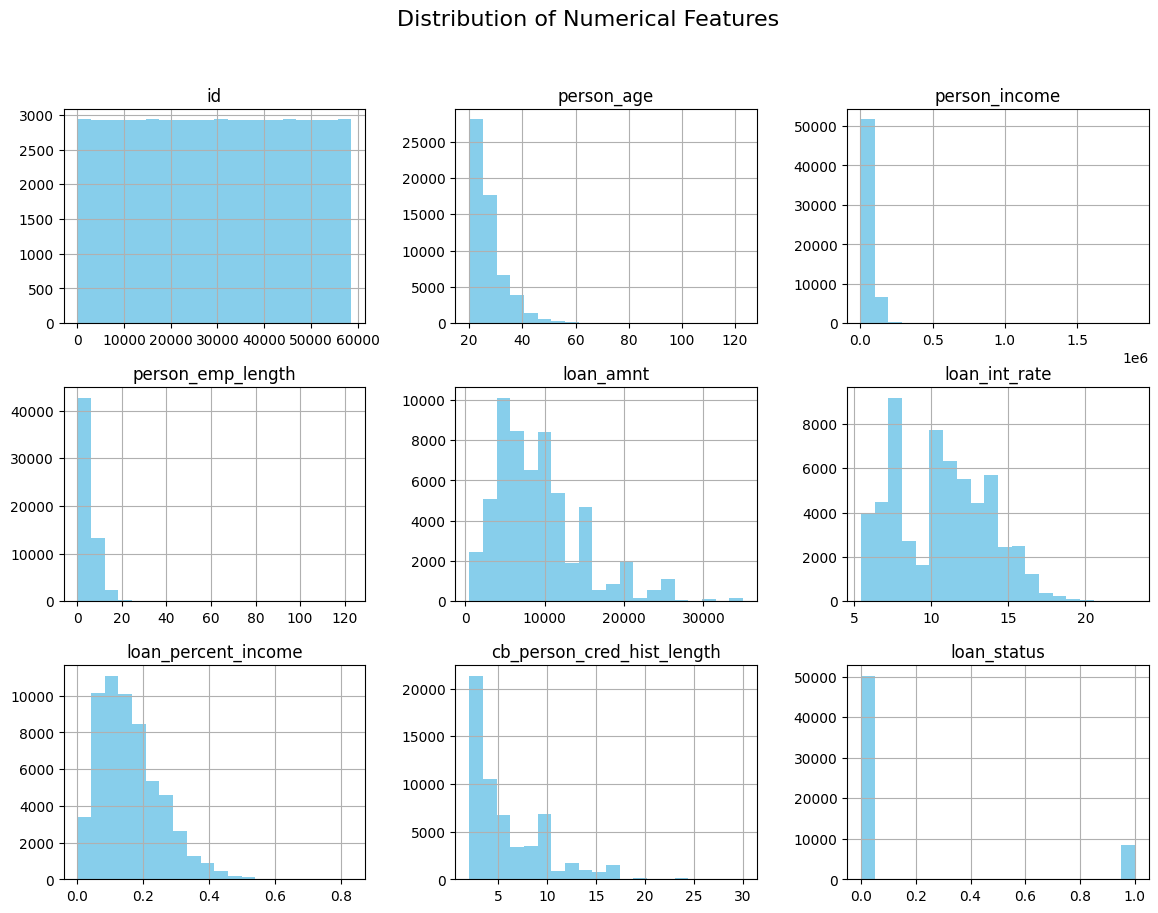

In [13]:
numerical_columns = df.select_dtypes(include=['number']).columns
df[numerical_columns].hist(bins=20, figsize=(14, 10), color='skyblue')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.show()

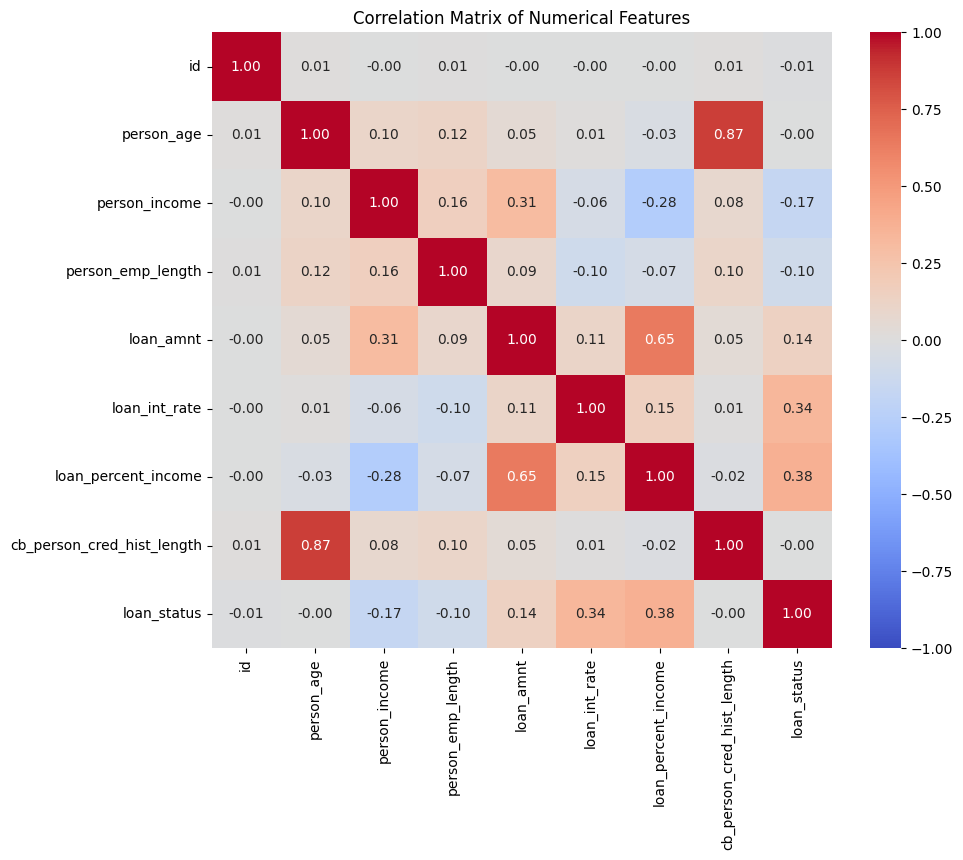

In [14]:
numerical_columns = df.select_dtypes(include=['number'])
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

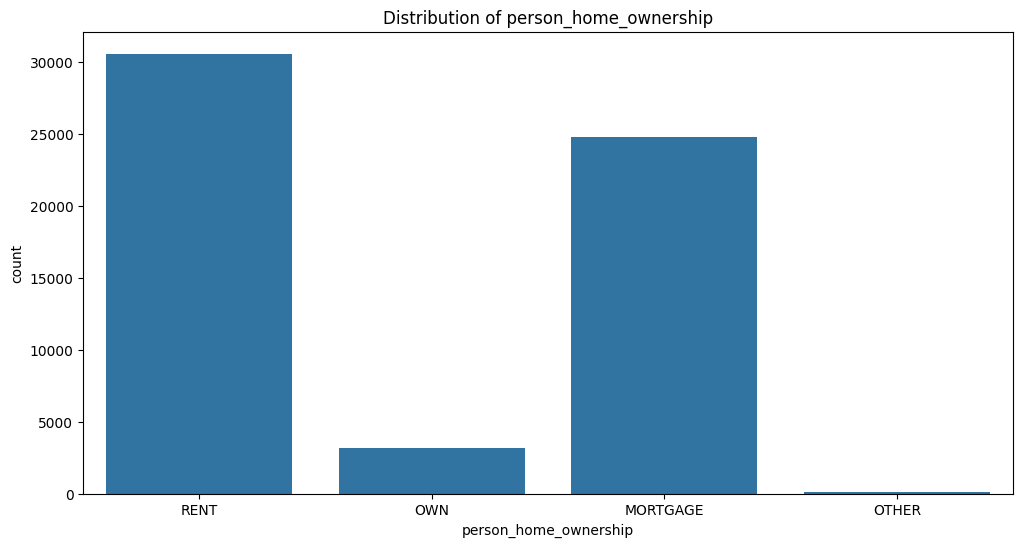

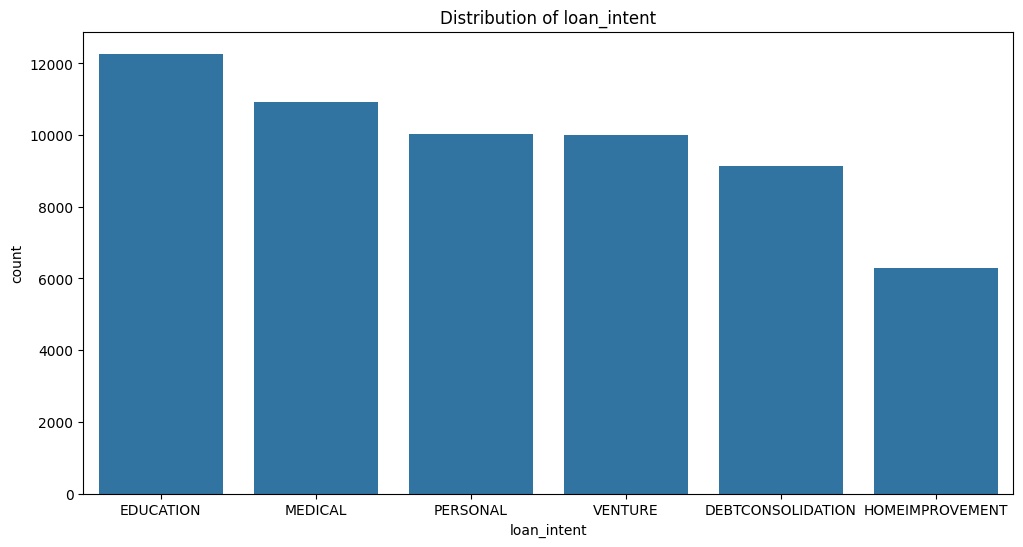

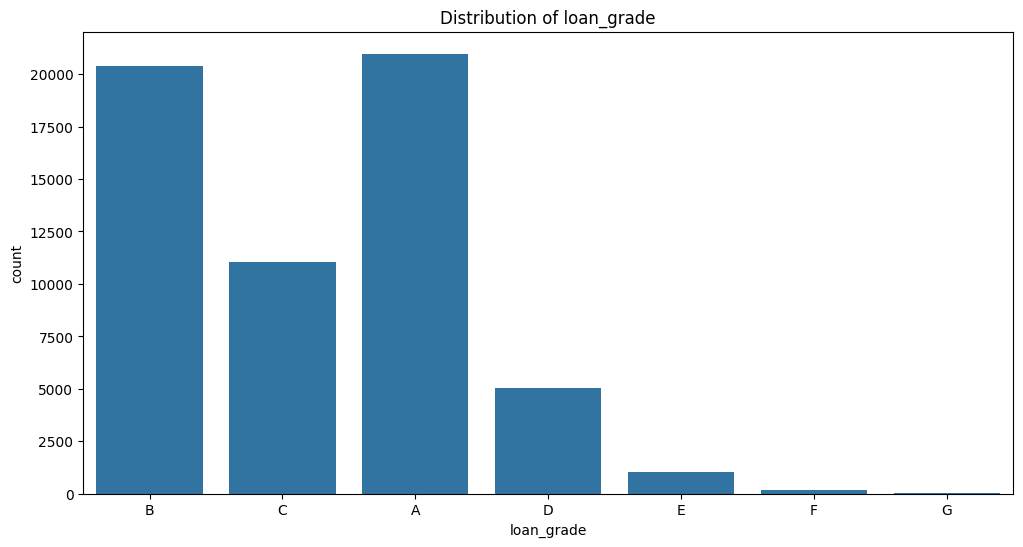

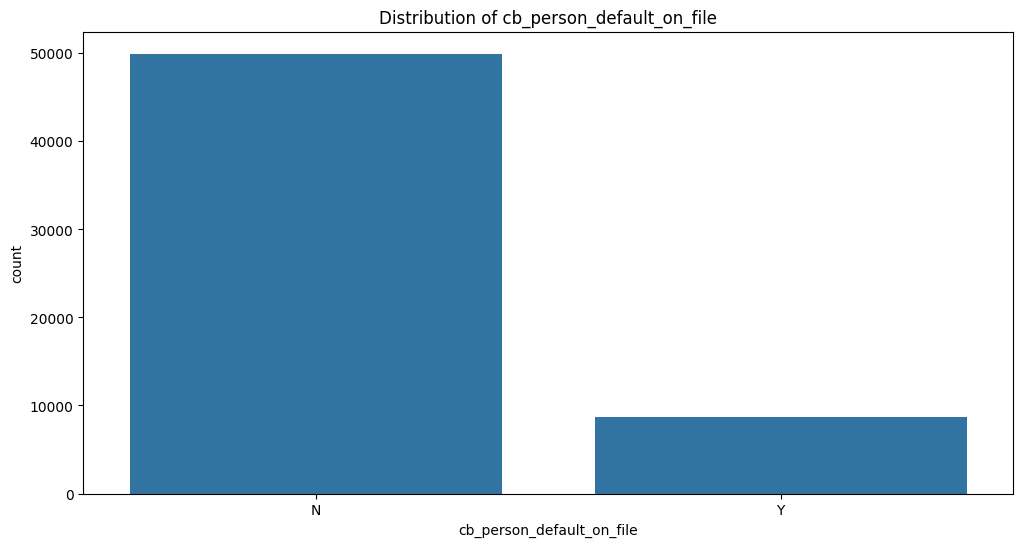

In [15]:
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

In [16]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())


for col in categorical_columns:
    if col in df.columns:  # Check if column exists in train
        df[col].fillna(df[col].mode()[0], inplace=True)


print("Missing values in data:\n", df.isnull().sum())

Missing values in data:
 id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


In [17]:
df = pd.get_dummies(df, drop_first=True)

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()

In [20]:
print("Columns in train DataFrame:", df.columns.tolist())

Columns in train DataFrame: ['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y']


In [21]:
df['loan_status'] = le.fit_transform(df['loan_status'])

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

print("Train Data Types after Encoding:\n", df.dtypes)

Train Data Types after Encoding:
 id                               int64
person_age                       int64
person_income                    int64
person_emp_length              float64
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_cred_hist_length       int64
loan_status                      int64
person_home_ownership_OTHER       bool
person_home_ownership_OWN         bool
person_home_ownership_RENT        bool
loan_intent_EDUCATION             bool
loan_intent_HOMEIMPROVEMENT       bool
loan_intent_MEDICAL               bool
loan_intent_PERSONAL              bool
loan_intent_VENTURE               bool
loan_grade_B                      bool
loan_grade_C                      bool
loan_grade_D                      bool
loan_grade_E                      bool
loan_grade_F                      bool
loan_grade_G                      bool
cb_person_default_on_file_Y       bool
dtype: object


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [24]:
X_train = df.drop('loan_status', axis=1)
y_train = df['loan_status']

In [25]:
print("Unique values in y_train:", y_train.unique())
print("Data type of y_train:", y_train.dtype)

Unique values in y_train: [-0.40745611  2.45425208]
Data type of y_train: float64


In [26]:
y_train = (y_train > 0.5).astype(int)

In [27]:
y_train = y_train.astype(int)

In [28]:
pip install imbalanced-learn

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter

# Suppose your dataset is already preprocessed
# X = features, y = target (Loan_Status for example)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Before SMOTE-Tomek:", Counter(y_train))

# Apply SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

print("After SMOTE-Tomek:", Counter(y_resampled))


Before SMOTE-Tomek: Counter({0: 40236, 1: 6680})
After SMOTE-Tomek: Counter({0: 40101, 1: 40101})


In [31]:
import pandas as pd
import numpy as np

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Store models
models = {
    "Gaussian NB": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Data after SMOTE-Tomek
# X_resampled, y_resampled -> training data
# X_test, y_test -> test data

results = []

for name, model in models.items():
    model.fit(X_resampled, y_resampled)   # Train
    y_pred = model.predict(X_test)        # Predict

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append([name, acc, prec, rec, f1])

# Convert to DataFrame for nice table view
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0          Gaussian NB  0.890272   0.619315  0.595210  0.607023
1  Logistic Regression  0.848069   0.480309  0.817964  0.605228
2             AdaBoost  0.872453   0.535251  0.791018  0.638473
3    Gradient Boosting  0.925569   0.725779  0.767066  0.745852
4          K Neighbors  0.847984   0.479174  0.778443  0.593201
5        Decision Tree  0.892574   0.600000  0.736527  0.661290
6        Random Forest  0.944752   0.857343  0.734132  0.790968
7              XGBoost  0.948930   0.891161  0.730539  0.802896
8             CatBoost  0.951317   0.907944  0.732335  0.810739


In [32]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier

# -------------------------------
# Train Final CatBoost Model
# -------------------------------
final_model = CatBoostClassifier(
    iterations=500,          # number of trees
    learning_rate=0.05,      # smaller LR for stability
    depth=8,                 # tree depth
    eval_metric="F1",        # optimize for F1-score
    random_state=42,
    verbose=100              # shows progress every 100 iterations
)

# Train model
final_model.fit(X_resampled, y_resampled, eval_set=(X_test, y_test), use_best_model=True)

# -------------------------------
# Evaluate Final Model
# -------------------------------
y_pred = final_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("Final CatBoost Model Performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# -------------------------------
# Save Model
# -------------------------------
final_model.save_model("model.cbm")
print("✅ Model saved as model.cbm")


0:	learn: 0.8556547	test: 0.7127660	best: 0.7127660 (0)	total: 50.3ms	remaining: 25.1s
100:	learn: 0.9451856	test: 0.7779498	best: 0.7779498 (100)	total: 3.47s	remaining: 13.7s
200:	learn: 0.9628174	test: 0.7990823	best: 0.7992152 (197)	total: 6.94s	remaining: 10.3s
300:	learn: 0.9693142	test: 0.8066556	best: 0.8069241 (277)	total: 11.2s	remaining: 7.39s
400:	learn: 0.9725272	test: 0.8081415	best: 0.8085390 (383)	total: 16.1s	remaining: 3.98s
499:	learn: 0.9741969	test: 0.8078588	best: 0.8090788 (459)	total: 21.8s	remaining: 0us

bestTest = 0.8090787717
bestIteration = 459

Shrink model to first 460 iterations.
Final CatBoost Model Performance:
Accuracy:  0.9512
Precision: 0.9140
Recall:    0.7257
F1-Score:  0.8091
✅ Model saved as model.cbm
